In [174]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [175]:
#Essentials
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

#sklearn "magic"
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline

#Oversampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


#Not sure about these ones yet
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

#Different scores
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score, roc_curve

#Nice to have
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display 
from ipywidgets import interactive, FloatSlider
from collections import Counter
#interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

#Let there be colours!
from termcolor import colored

%matplotlib inline

In [176]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [177]:
# Postgres info to connect

connection_args = {
    'host': '18.222.192.127', 
    'user': 'ubuntu',    # username
    'dbname': 'student_grades',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [178]:
#failures: 0.275, higher: 0.102, discipline: 0.09, absences: 0.081, goout: 0.041, age: 0.038, Fedu: 0.037, Medu: 0.033, freetime: 0.03
#Walc: 0.026, famrel: 0.025, Dalc: 0.025, health: 0.023, guardian: 0.021, schoolsup: 0.021, paid: 0.018, studytime: 0.017, traveltime: 0.016
#activities: 0.015, sex: 0.013, address: 0.011, famsize: 0.011, romantic: 0.011, famsup: 0.01, internet: 0.009, Pstatus: 0.003

In [179]:
### Let's combine the two SQL tables into one

append_query = """SELECT failures, higher, discipline, absences, goout, age, "Fedu", "Medu", freetime, "Walc", famrel, 
                            "Dalc", health, guardian, paid, final_grade_label
                    FROM maths_grades
                    WHERE age BETWEEN 15 AND 19

                    UNION ALL

                    SELECT failures, higher, discipline, absences, goout, age, "Fedu", "Medu", freetime, "Walc", famrel, 
                            "Dalc", health, guardian, paid, final_grade_label 
                    FROM portuguese_grades
                    WHERE age BETWEEN 15 AND 19
                    """

grades = pd_sql.read_sql(append_query, connection)

In [180]:
grades.head()

,failures,higher,discipline,absences,goout,age,Fedu,Medu,freetime,Walc,famrel,Dalc,health,guardian,paid,final_grade_label
0,0,1,maths,6,4,18,4,4,3,1,4,1,3,mother,0,Fail
1,0,1,maths,4,3,17,1,1,3,1,5,1,3,father,0,Fail
2,3,1,maths,10,2,15,1,1,3,3,4,2,3,mother,1,Pass
3,0,1,maths,2,2,15,2,4,2,1,3,1,5,mother,1,Pass
4,0,1,maths,4,2,16,3,3,3,2,4,1,5,father,1,Pass


### Let's dummify some variables

In [181]:
#Sanity check
grades.columns

Index(['failures', 'higher', 'discipline', 'absences', 'goout', 'age', 'Fedu',
       'Medu', 'freetime', 'Walc', 'famrel', 'Dalc', 'health', 'guardian',
       'paid', 'final_grade_label'],
      dtype='object')

In [182]:
# #dummify sex (M=0, F=1)
#grades['sex'].replace({'M': 0, 'F': 1}, inplace=True)

# #dummify address (U(urban)=0, R(rural)=1)
# grades['address'].replace({'U': 0, 'R': 1}, inplace=True)

# #dummify famsize (LE3(less than/equal to 3)=0, GT3(greater than 3)=1)
# grades['famsize'].replace({'LE3': 0, 'GT3': 1}, inplace=True)

# #dummify Pstatus(parent status) (T(together)=0, A(apart)=1)
# grades['Pstatus'].replace({'T': 0, 'A': 1}, inplace=True)

#dummify guardian (other=0, mother=1, father=2)
grades['guardian'].replace({'other': 0, 'mother': 1, 'father': 2}, inplace=True)

#dummify discipline (maths=0, portuguese=1)
grades['discipline'].replace({'maths': 0, 'portuguese': 1}, inplace=True)

# #drop G3 column (obviously!)
# grades.drop(columns='G3', inplace=True)

#dummify target variable
grades['final_grade_label'].replace({'Fail': 0, 'Pass': 1}, inplace=True)


### Feature and target analysis

In [183]:
print(grades['final_grade_label'].value_counts(), '\n')
print('% of Pass:', str(round(814 / 1044, 2)))
print('% of Fail:', str(round(230 / 1044, 2)), '\n')
print('Pass to Fail ratio in the dataset:', str(int((814 / 1044)*100))+':'+str(int((230 / 1044)*100)))
print('Percentage of Majority grade (Pass)', str(round((814 / 1044) *100, 0)))

1    804
0    226
Name: final_grade_label, dtype: int64 

% of Pass: 0.78
% of Fail: 0.22 

Pass to Fail ratio in the dataset: 77:22
Percentage of Majority grade (Pass) 78.0


> **This is not good!** I should look into oversampling or undersampling further down the line

In [184]:
feat, grade_label = grades.iloc[:, :-1], grades.iloc[:, -1]

In [185]:
# print(feat.head())
# print(grade_label.head())

In [186]:
#grades.corr()

## Train - test split

In [187]:
feat_train, feat_test, grade_label_train, grade_label_test = train_test_split(feat, grade_label, test_size=0.2
                                                                                  , random_state=42, stratify=grade_label)

# Modelling Time

### Let's compare the models at their best

In [188]:
model_list = [RandomForestClassifier(n_estimators=150, class_weight=None, max_depth=5, min_samples_leaf=5, min_samples_split=2, random_state=42), 
              BernoulliNB(alpha=0.1, fit_prior=True)]

model_names = ['Random Forest', 'Naive Bayes Bernoulli']

In [189]:
model_precision_scores = []
model_auc_scores = []
all_models = {}

for i in range(len(model_list)):
    try_model = model_list[i]
    try_model.fit(feat_train, grade_label_train)
    all_models[model_names[i]] = try_model
    cv_precision_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='average_precision')
    cv_auc_score = cross_val_score(try_model, feat_train, grade_label_train, cv=10,
                                scoring='roc_auc')
    model_precision_scores.append((model_names[i], round(np.mean(cv_precision_score), 3)))
    model_auc_scores.append((model_names[i], round(np.mean(cv_auc_score), 3)))
    
print('Average Precision score: ' + colored(sorted(model_precision_scores, key=lambda x: x[1], reverse=True), 'green'))
print('Average AUC score: ' + colored(sorted(model_auc_scores, key=lambda x: x[1], reverse=True), 'green'))


Average Precision score: [('Random Forest', 0.924), ('Naive Bayes Bernoulli', 0.906)]
Average AUC score: [('Random Forest', 0.789), ('Naive Bayes Bernoulli', 0.774)]


## Let's checkout AUC scores and ROC curves

In [190]:
#roc_curve function calculates the true positive, false positive and a threshold
fpr_RandFor, tpr_RandFor, thresholds_RandFor = roc_curve(grade_label_train, all_models['Random Forest'].predict_proba(feat_train)[:,1])
fpr_NBB, tpr_NBB, thresholds_NBB = roc_curve(grade_label_train, all_models['Naive Bayes Bernoulli'].predict_proba(feat_train)[:,1])

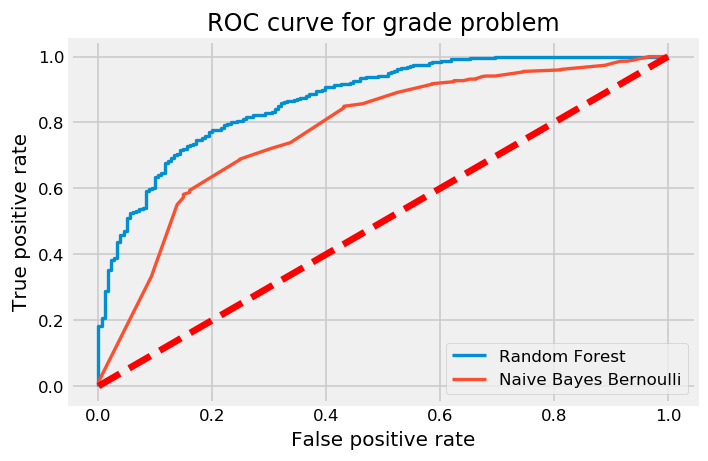

In [191]:
plt.figure(dpi=120)
plt.plot(fpr_RandFor, tpr_RandFor, lw=2, label='Random Forest')
plt.plot(fpr_NBB, tpr_NBB, lw=2, label='Naive Bayes Bernoulli')
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for grade problem');

>> **It's decided! Random Forest and Naive Bayes (Bernoulli) are going through to the next round!**

In [192]:
#Let's record the two best models
Random_Forest = all_models['Random Forest']
Naive_Bayes_B = all_models['Naive Bayes Bernoulli']

In [193]:
Random_Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Can we do better with oversampling?

#### Random Over Sampler 

In [194]:
ROS = RandomOverSampler(random_state=42)
feat_train_ROS, grade_label_train_ROS = ROS.fit_sample(feat_train, grade_label_train)

In [195]:
Counter(grade_label_train_ROS)

Counter({1: 643, 0: 643})

In [196]:
#Create a new Random Forest model and fit with "smoted" values
Random_Forest_ROS = Random_Forest
Random_Forest_ROS.fit(feat_train_ROS, grade_label_train_ROS)

Naive_Bayes_B_ROS = Naive_Bayes_B
Naive_Bayes_B_ROS.fit(feat_train_ROS, grade_label_train_ROS);

The scores on original training set are:

Accuracy score after Random Over Sampler is: 0.819
Recall score after Random Over Sampler is: 0.844
Precision score after Random Over Sampler is: 0.917
F1 score after Random Over Sampler is: 0.879
(Random Over Sampler): The mean of 10 fold cross validation precision score on Random Forest model is 0.803
[[132  49]
 [100 543]]


array([[132,  49],
       [100, 543]])

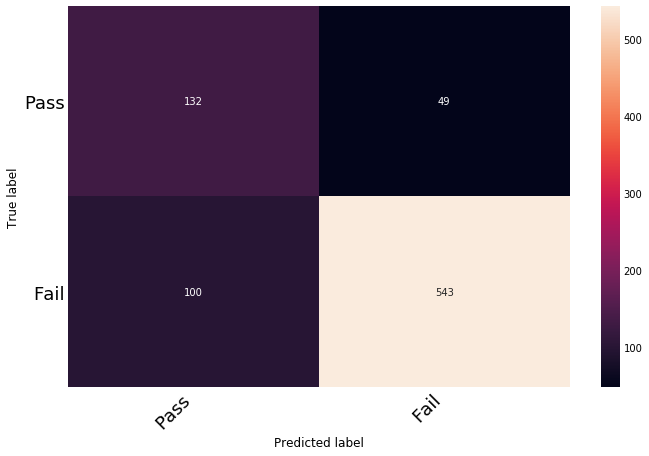

In [197]:
print('The scores on original training set are:\n')
print('Accuracy score after Random Over Sampler is:', colored(str(round(Random_Forest_ROS.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after Random Over Sampler is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))
print('Precision score after Random Over Sampler is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))
print('F1 score after Random Over Sampler is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_ROS.predict(feat_train)), 3)), 'magenta'))

#Checking precision score on random over sampler model
RF_ROS_cross_val = cross_val_score(Random_Forest_ROS, feat_train, grade_label_train, scoring='precision', cv = 10)
print('(Random Over Sampler): The mean of 10 fold cross validation precision score on Random Forest model is', 
                  colored(str(round(np.mean(RF_ROS_cross_val), 3)), 'magenta'))

RF_ROS_cm = confusion_matrix(grade_label_train, Random_Forest_ROS.predict(feat_train))
print(RF_ROS_cm)
RF_ROS_cm = print_confusion_matrix(RF_ROS_cm, ['Pass', 'Fail'])

confusion_matrix(grade_label_train, Random_Forest_ROS.predict(feat_train))

> Not with Random Over Sampler, apparently!

#### SMOTE

In [198]:
SMO = SMOTE(random_state=42)
feat_train_smoted, grade_label_train_smoted = SMO.fit_sample(feat_train, grade_label_train)

In [199]:
Counter(grade_label_train_smoted)

Counter({1: 643, 0: 643})

In [200]:
Random_Forest_SMOTE = Random_Forest
Random_Forest_SMOTE.fit(feat_train_smoted, grade_label_train_smoted)

Naive_Bayes_B_SMOTE = Naive_Bayes_B
Naive_Bayes_B_SMOTE.fit(feat_train_smoted, grade_label_train_smoted);

Test scores on original training set are:

Accuracy score after SMOTE is: 0.833
Recall score after SMOTE is: 0.998
Precision score after SMOTE is: 0.824
F1 score after SMOTE is: 0.903
(SMOTE): The mean of 10 fold cross validation precision score on Random Forest model is 0.803


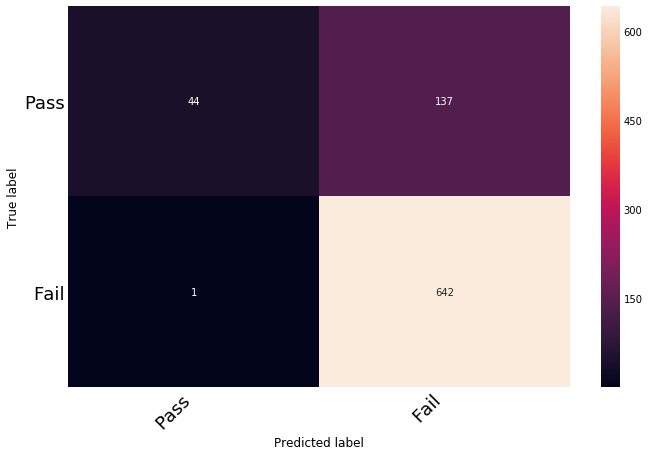

In [208]:
print('Test scores on original training set are:\n')
print('Accuracy score after SMOTE is:', colored(str(round(Random_Forest_SMOTE.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after SMOTE is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))
print('Precision score after SMOTE is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))
print('F1 score after SMOTE is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_SMOTE.predict(feat_train)), 3)), 'magenta'))

#Checking accuracy score on smoted model
RF_smoted_cross_val = cross_val_score(Random_Forest_SMOTE, feat_train, grade_label_train, scoring='precision', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation precision score on Random Forest model is', 
                          colored(str(round(np.mean(RF_smoted_cross_val), 3)), 'magenta'))

#What's my confusion matrix looking like?
RF_smoted_cm = confusion_matrix(grade_label_train, Random_Forest_SMOTE.predict(feat_train))
RF_smoted_cm = print_confusion_matrix(RF_smoted_cm, ['Pass', 'Fail'])

> Not much improvement with SMOTE

#### ADASYN

In [202]:
ADA = ADASYN(random_state=42)
feat_train_adasyn, grade_label_train_adasyn = ADA.fit_sample(feat_train, grade_label_train)

In [203]:
Counter(grade_label_train_adasyn)

Counter({1: 643, 0: 642})

In [204]:
Random_Forest_ADASYN = Random_Forest
Random_Forest_ADASYN.fit(feat_train_adasyn, grade_label_train_adasyn)

Naive_Bayes_B_ADASYN = Naive_Bayes_B
Naive_Bayes_B_ADASYN.fit(feat_train_adasyn, grade_label_train_adasyn);

Test scores on original training set are:

Accuracy score after ADASYN is: 0.841
Recall score after ADASYN is: 0.902
Precision score after ADASYN is: 0.895
F1 score after ADASYN is: 0.899
(SMOTE): The mean of 10 fold cross validation precision score on Random Forest model is 0.803


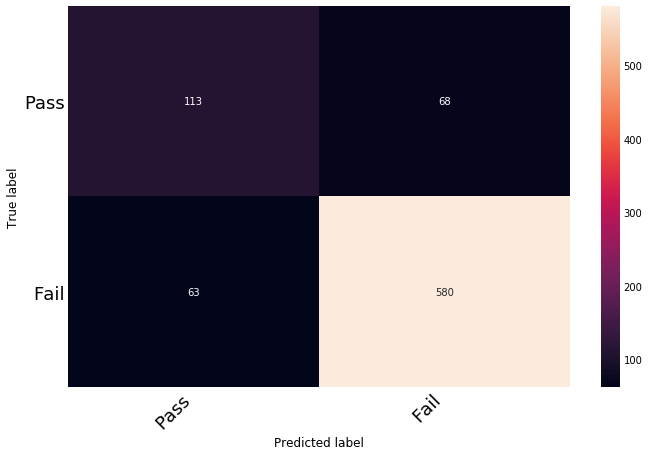

In [205]:
print('Test scores on original training set are:\n')
print('Accuracy score after ADASYN is:', colored(str(round(Random_Forest_ADASYN.score(feat_train, grade_label_train), 3)), 'magenta'))
print('Recall score after ADASYN is:', colored(str(round(recall_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))
print('Precision score after ADASYN is:', colored(str(round(precision_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))
print('F1 score after ADASYN is:', colored(str(round(f1_score(
                                        grade_label_train, Random_Forest_ADASYN.predict(feat_train)), 3)), 'magenta'))

#Checking accuracy score on smoted model
RF_smoted_cross_val = cross_val_score(Random_Forest_ADASYN, feat_train, grade_label_train, scoring='precision', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation precision score on Random Forest model is', 
                          colored(str(round(np.mean(RF_smoted_cross_val), 3)), 'magenta'))

#What's my confusion matrix looking like?
RF_adasyn_cm = confusion_matrix(grade_label_train, Random_Forest_ADASYN.predict(feat_train))
RF_adasyn_cm = print_confusion_matrix(RF_adasyn_cm, ['Pass', 'Fail'])

### So does Oversampling help?

In [206]:
mini_model_list = [Random_Forest, Random_Forest_ROS, Random_Forest_SMOTE, Random_Forest_ADASYN, Naive_Bayes_B, Naive_Bayes_B_ROS
                  , Naive_Bayes_B_SMOTE, Naive_Bayes_B_ADASYN]
mini_model_names = ['RF', 'RF with ROS', 'RF with SMOTE', 'RF with ADASYN', 'Naive Bayes Bernoulli', 'NBB with ROS', 'NBB with SMOTE', 'NBB with ADASYN']
oversample_model_scores = []

for i in range(len(mini_model_list)):
    try_model = mini_model_list[i]
    try_model.fit(feat_train, grade_label_train)
    the_precision_score = cross_val_score(try_model, feat_train, grade_label_train, scoring='precision', cv=10)
    oversample_model_scores.append((mini_model_names[i], round(np.mean(the_precision_score), 3)))
    
print(oversample_model_scores)

[('RF', 0.803), ('RF with ROS', 0.803), ('RF with SMOTE', 0.803), ('RF with ADASYN', 0.803), ('Naive Bayes Bernoulli', 0.831), ('NBB with ROS', 0.831), ('NBB with SMOTE', 0.831), ('NBB with ADASYN', 0.831)]


> Shocker!

## Feature selection (with Random Forest)

In [207]:
feat_imp = []
for feat, imp in zip([f for f in feat_train.columns], Random_Forest.feature_importances_):
    feat_imp.append((feat, round(imp, 3)))

for feat, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
    print(str(feat)+':', str(imp))

failures: 0.283
absences: 0.102
discipline: 0.098
higher: 0.087
goout: 0.061
famrel: 0.044
age: 0.043
Fedu: 0.042
Walc: 0.042
Medu: 0.039
freetime: 0.037
health: 0.035
paid: 0.031
Dalc: 0.029
guardian: 0.026
